In [21]:
# %% [code]
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random

# File paths for your three classifiers (ensemble_avg)
external_avg_path = "/home/mezher/Documents/Deauville_DeepLearning/prediction/external/ensemble_avg.csv"
scratch_avg_path  = "/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run7/ensemble_avg.csv"
transfer_avg_path = "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12v3/ensemble_avg.csv"

df_external = pd.read_csv(external_avg_path)
df_scratch  = pd.read_csv(scratch_avg_path)
df_transfer = pd.read_csv(transfer_avg_path)

# 3) Merge on scan_id (like your standard approach)
df_merged = df_external[['scan_id', 'target', 'ensemble_prob']].rename(
    columns={'ensemble_prob': 'external_prob'}
)
df_merged = df_merged.merge(df_scratch[['scan_id', 'ensemble_prob']], on='scan_id', how='inner')
df_merged.rename(columns={'ensemble_prob': 'scratch_prob'}, inplace=True)

df_merged = df_merged.merge(df_transfer[['scan_id', 'ensemble_prob']], on='scan_id', how='inner')
df_merged.rename(columns={'ensemble_prob': 'transfer_prob'}, inplace=True)

print("Columns:", df_merged.columns)
print("Number of rows:", len(df_merged))

# 4) Extract arrays
y_true = df_merged['target'].values
prob_ext = df_merged['external_prob'].values
prob_scratch = df_merged['scratch_prob'].values
prob_trans = df_merged['transfer_prob'].values

# 5) Let's see raw AUC
print("AUC External :", roc_auc_score(y_true, prob_ext))
print("AUC Scratch  :", roc_auc_score(y_true, prob_scratch))
print("AUC Transfer :", roc_auc_score(y_true, prob_trans))




Columns: Index(['scan_id', 'target', 'external_prob', 'scratch_prob', 'transfer_prob'], dtype='object')
Number of rows: 289
AUC External : 0.9153061224489797
AUC Scratch  : 0.8978741496598639
AUC Transfer : 0.932482993197279


In [34]:
from MLstatkit.stats import Delong_test

def delong_one_sided(y_true, scoresA, scoresB, side="+"):
    """
    side="+": H₁ : AUC_A > AUC_B
    side="-": H₁ : AUC_A < AUC_B
    Returns (z, two_sided_p, one_sided_p)
    """
    z, p_two = Delong_test(y_true, scoresA, scoresB)

    if side not in ("+", "-"):
        raise ValueError("side must be '+' or '-'")

    # keep the tail that supports H₁
    if (side == "+" and z > 0) or (side == "-" and z < 0):
        p_one = p_two / 2.0
    else:                     # observed effect in the wrong direction
        p_one = 1.0 - p_two / 2.0

    return z, p_two, p_one


alpha = 0.05          # significance threshold

# (a) Transfer better than External
z, p_two, p_one = delong_one_sided(y_true, prob_trans, prob_ext, side="+")
print(f"Transfer > External?  z = {z:.4f},  one‑sided p = {p_one:.4f}"
      f"  --> {'YES ✅' if p_one < alpha else 'No ❌'}")

# (b) Transfer better than Scratch
z, p_two, p_one = delong_one_sided(y_true, prob_trans, prob_scratch, side="+")
print(f"Transfer > Scratch?   z = {z:.4f},  one‑sided p = {p_one:.4f}"
      f"  --> {'YES ✅' if p_one < alpha else 'No ❌'}")

# (c) Scratch better than External
z, p_two, p_one = delong_one_sided(y_true, prob_scratch, prob_ext, side="+")
print(f"Scratch > External?   z = {z:.4f},  one‑sided p = {p_one:.4f}"
      f"  --> {'YES ✅' if p_one < alpha else 'No ❌'}")


Transfer > External?  z = -2.1123,  one‑sided p = 0.9827  --> No ❌
Transfer > Scratch?   z = -1.9343,  one‑sided p = 0.9735  --> No ❌
Scratch > External?   z = -0.9619,  one‑sided p = 0.8320  --> No ❌


In [37]:
from MLstatkit.stats import Delong_test

# 6) Delong_test
def run_delong(nameA, scoresA, nameB, scoresB):
    z_score, p_value = Delong_test(y_true, scoresA, scoresB)
    print(f"--- DeLong test: {nameA} vs. {nameB} ---")
    print(f"z-score = {z_score:.4f}, p-value = {p_value:.4f}")
    print("Significant difference ✅" if p_value < 0.05 else "No significant difference ❌")
    print()

# Pairwise comparisons
run_delong("External", prob_ext, "Scratch", prob_scratch)
run_delong("External", prob_ext, "Transfer", prob_trans)
run_delong("Scratch",  prob_scratch, "Transfer", prob_trans)

--- DeLong test: External vs. Scratch ---
z-score = -0.9619, p-value = 0.3361
No significant difference ❌

--- DeLong test: External vs. Transfer ---
z-score = -2.1123, p-value = 0.0347
Significant difference ✅

--- DeLong test: Scratch vs. Transfer ---
z-score = -1.9343, p-value = 0.0531
No significant difference ❌



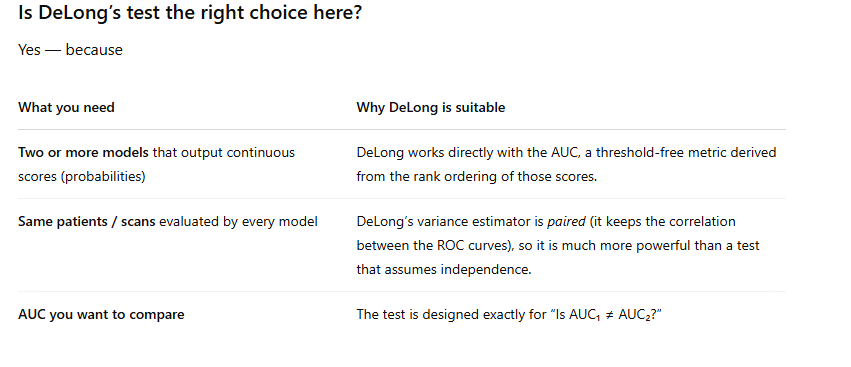

Should i go one sided or not ? 


In [31]:
from statsmodels.stats.contingency_tables import mcnemar

# --- Step 1: Apply thresholds to binarize predictions ---
thresholds = {
    "external": 0.44553510696,
    "scratch": 0.383300168481,
    "transfer": 0.14830395961250004
}

df_merged['external_label'] = (df_merged['external_prob'] >= thresholds['external']).astype(int)
df_merged['scratch_label'] = (df_merged['scratch_prob'] >= thresholds['scratch']).astype(int)
df_merged['transfer_label'] = (df_merged['transfer_prob'] >= thresholds['transfer']).astype(int)

y_true = df_merged['target'].values

# --- Step 2: Define function to run McNemar test on two prediction columns ---
def run_mcnemar_test(label_a, label_b, label_name_a, label_name_b):
    a_pred = df_merged[label_a].values
    b_pred = df_merged[label_b].values

    # Compute contingency table
    b = np.sum((a_pred == y_true) & (b_pred != y_true))  # A correct, B wrong
    c = np.sum((a_pred != y_true) & (b_pred == y_true))  # A wrong, B correct

    table = [[0, b],
             [c, 0]]

    result = mcnemar(table, exact=True)
    print(f"McNemar test: {label_name_a} vs. {label_name_b}")
    print(f"  ➤ statistic = {result.statistic}, p-value = {result.pvalue:.4f}")
    print("  ➤", "Significant difference ✅" if result.pvalue < 0.05 else "No significant difference ❌")
    print()

# --- Step 3: Run tests ---
run_mcnemar_test('external_label', 'scratch_label', 'External', 'Scratch')
run_mcnemar_test('external_label', 'transfer_label', 'External', 'Transfer')
run_mcnemar_test('scratch_label', 'transfer_label', 'Scratch', 'Transfer')


McNemar test: External vs. Scratch
  ➤ statistic = 12.0, p-value = 0.5716
  ➤ No significant difference ❌

McNemar test: External vs. Transfer
  ➤ statistic = 6.0, p-value = 0.0000
  ➤ Significant difference ✅

McNemar test: Scratch vs. Transfer
  ➤ statistic = 8.0, p-value = 0.0000
  ➤ Significant difference ✅



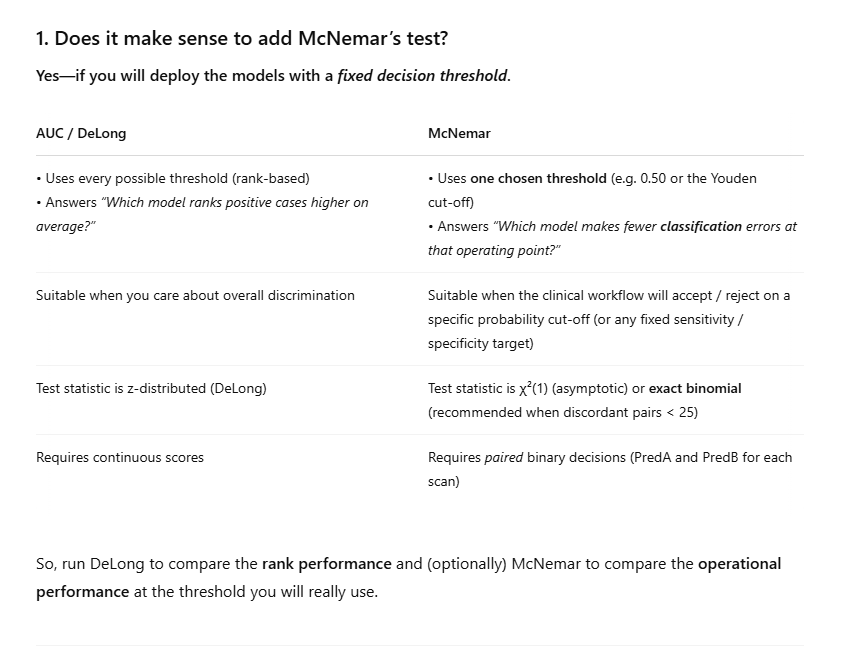

In [23]:
from MLstatkit.stats import Bootstrapping

original_score, lower_ci, upper_ci = Bootstrapping(
    y_true=y_true,
    y_prob=prob_ext,           # <-- use y_prob, not prob
    metric_str='roc_auc',
    n_bootstraps=1000,
    confidence_level=0.95
)

print(f"External Model => AUROC: {original_score:.3f}, 95% CI: [{lower_ci:.3f}, {upper_ci:.3f}]")

# For the Scratch model:
original_score_scratch, lower_ci_scratch, upper_ci_scratch = Bootstrapping(
    y_true=y_true,
    y_prob=prob_scratch,   # predicted probabilities from the scratch model
    metric_str='roc_auc',  # or 'pr_auc', 'f1', etc.
    n_bootstraps=1000,
    confidence_level=0.95
)
print(f"Scratch Model => AUROC: {original_score_scratch:.3f}, "
      f"95% CI: [{lower_ci_scratch:.3f}, {upper_ci_scratch:.3f}]")

# For the Transfer model:
original_score_trans, lower_ci_trans, upper_ci_trans = Bootstrapping(
    y_true=y_true,
    y_prob=prob_trans,      # predicted probabilities from the transfer model
    metric_str='roc_auc',
    n_bootstraps=1000,
    confidence_level=0.95
)
print(f"Transfer Model => AUROC: {original_score_trans:.3f}, "
      f"95% CI: [{lower_ci_trans:.3f}, {upper_ci_trans:.3f}]")


Bootstrapping roc_auc:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping roc_auc: 100%|██████████| 1000/1000 [00:00<00:00, 1176.16it/s]


External Model => AUROC: 0.915, 95% CI: [0.858, 0.961]


Bootstrapping roc_auc: 100%|██████████| 1000/1000 [00:00<00:00, 1195.68it/s]


Scratch Model => AUROC: 0.898, 95% CI: [0.835, 0.947]


Bootstrapping roc_auc: 100%|██████████| 1000/1000 [00:00<00:00, 1194.10it/s]

Transfer Model => AUROC: 0.932, 95% CI: [0.881, 0.970]


In [24]:
import numpy as np
from sklearn.metrics import roc_auc_score

def bootstrap_auc_diff_test(
    y_true,
    preds_modelA,
    preds_modelB,
    n_boot=2000,
    alpha=0.05,
    random_state=42
):
    """
    Perform a nonparametric bootstrap test for the difference in AUC
    between two classifiers (model A and model B).

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth binary labels (0 or 1).
    preds_modelA : array-like of shape (n_samples,)
        Continuous predicted scores or probabilities for Model A.
    preds_modelB : array-like of shape (n_samples,)
        Continuous predicted scores or probabilities for Model B.
    n_boot : int, default=2000
        Number of bootstrap replicates to generate.
    alpha : float, default=0.05
        Significance level for confidence intervals (e.g., 0.05 => 95% CI).
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    obs_diff : float
        Observed difference in AUC (AUC(A) - AUC(B)) on the original data.
    p_value : float
        Two-sided bootstrap p-value: fraction of bootstrap diffs
        that are >= |obs_diff| in magnitude.
    ci : tuple of floats
        (lower_ci, upper_ci) percentile-based confidence interval for the difference.

    Example
    -------
    obs_diff, p_val, (ci_lower, ci_upper) = bootstrap_auc_diff_test(
        y_true, scoresA, scoresB, n_boot=2000, alpha=0.05
    )
    """
    rng = np.random.default_rng(random_state)
    
    # 1) Compute the observed difference in AUC on the full dataset
    aucA_full = roc_auc_score(y_true, preds_modelA)
    aucB_full = roc_auc_score(y_true, preds_modelB)
    obs_diff = aucA_full - aucB_full

    n = len(y_true)
    diffs = np.zeros(n_boot, dtype=float)

    # 2) Bootstrap loop
    for i in range(n_boot):
        # Sample indices with replacement
        sample_idx = rng.integers(0, n, size=n)
        # Compute AUC on the bootstrap replicate
        aucA_boot = roc_auc_score(y_true[sample_idx], preds_modelA[sample_idx])
        aucB_boot = roc_auc_score(y_true[sample_idx], preds_modelB[sample_idx])
        diffs[i] = aucA_boot - aucB_boot

    # 3) Compute two-sided p-value: proportion of diffs more extreme than obs_diff
    more_extreme = np.sum(np.abs(diffs) >= np.abs(obs_diff))
    p_value = (more_extreme + 1) / (n_boot + 1)  # "small-sample" correction

    # 4) Compute confidence interval from diffs
    lower_bound = np.percentile(diffs, 100 * (alpha / 2))
    upper_bound = np.percentile(diffs, 100 * (1 - alpha / 2))
    ci = (lower_bound, upper_bound)

    return obs_diff, p_value, ci


In [25]:
# Suppose we have:
# y_true = df_merged['target'].values
# prob_ext = df_merged['external_prob'].values
# prob_scratch = df_merged['scratch_prob'].values
# prob_trans = df_merged['transfer_prob'].values

# 1) Compare External vs. Scratch
obs_diff_es, p_es, ci_es = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_ext,
    preds_modelB=prob_scratch,
    n_boot=2000,
    alpha=0.05,
    random_state=42
)
print("\n--- External vs. Scratch ---")
print(f"Observed AUC diff = {obs_diff_es:.4f}")
print(f"95% CI for diff   = [{ci_es[0]:.4f}, {ci_es[1]:.4f}]")
print(f"p-value           = {p_es:.4f}")
print("=> Significant difference ✅" if p_es < 0.05 else "No significant difference ❌")

# 2) Compare External vs. Transfer
obs_diff_et, p_et, ci_et = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_ext,
    preds_modelB=prob_trans,
    n_boot=2000,
    alpha=0.05,
    random_state=42
)
print("\n--- External vs. Transfer ---")
print(f"Observed AUC diff = {obs_diff_et:.4f}")
print(f"95% CI for diff   = [{ci_et[0]:.4f}, {ci_et[1]:.4f}]")
print(f"p-value           = {p_et:.4f}")
print("=> Significant difference ✅" if p_et < 0.05 else "No significant difference ❌")

# 3) Compare Scratch vs. Transfer
obs_diff_st, p_st, ci_st = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_scratch,
    preds_modelB=prob_trans,
    n_boot=2000,
    alpha=0.05,
    random_state=42
)
print("\n--- Scratch vs. Transfer ---")
print(f"Observed AUC diff = {obs_diff_st:.4f}")
print(f"95% CI for diff   = [{ci_st[0]:.4f}, {ci_st[1]:.4f}]")
print(f"p-value           = {p_st:.4f}")
print("=> Significant difference ✅" if p_st < 0.05 else "No significant difference ❌")



--- External vs. Scratch ---
Observed AUC diff = 0.0174
95% CI for diff   = [-0.0166, 0.0526]
p-value           = 0.5042
No significant difference ❌

--- External vs. Transfer ---
Observed AUC diff = -0.0172
95% CI for diff   = [-0.0344, -0.0021]
p-value           = 0.4763
No significant difference ❌

--- Scratch vs. Transfer ---
Observed AUC diff = -0.0346
95% CI for diff   = [-0.0715, -0.0010]
p-value           = 0.4688
No significant difference ❌


Class imbalance check:
  Pos count = 49, Neg count = 240, Ratio pos = 0.17


[DEBUG] Observed difference: 0.0174
[DEBUG] Two-sided p-value:   0.5042
[DEBUG] 5% CI for diff: [-0.0166, 0.0526]
Distribution among 2000 bootstrap replicates:
  diffs <  0: 331, diffs >  0: 1669, diffs == 0: 0


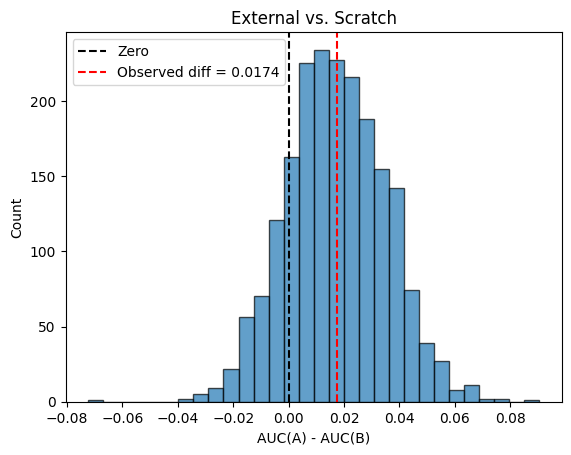

--- External vs. Scratch ---
Observed AUC diff = 0.0174
95% CI for diff   = [-0.0166, 0.0526]
p-value           = 0.5042
No significant difference ❌

[DEBUG] Observed difference: -0.0172
[DEBUG] Two-sided p-value:   0.4763
[DEBUG] 5% CI for diff: [-0.0344, -0.0021]
Distribution among 2000 bootstrap replicates:
  diffs <  0: 1978, diffs >  0: 22, diffs == 0: 0


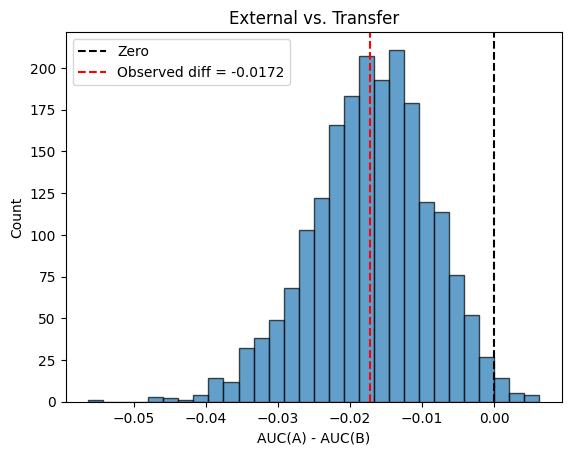


--- External vs. Transfer ---
Observed AUC diff = -0.0172
95% CI for diff   = [-0.0344, -0.0021]
p-value           = 0.4763
No significant difference ❌

[DEBUG] Observed difference: -0.0346
[DEBUG] Two-sided p-value:   0.4688
[DEBUG] 5% CI for diff: [-0.0715, -0.0010]
Distribution among 2000 bootstrap replicates:
  diffs <  0: 1957, diffs >  0: 42, diffs == 0: 1


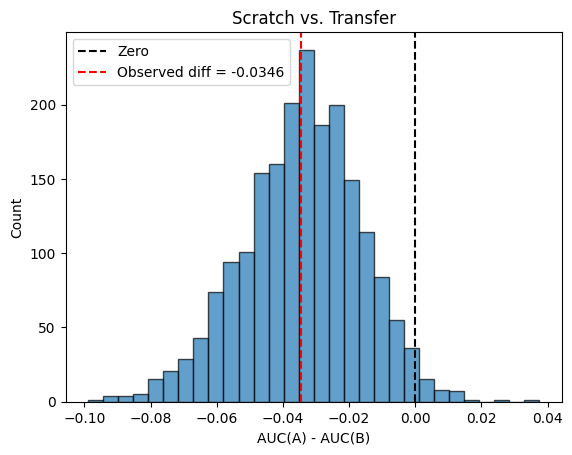


--- Scratch vs. Transfer ---
Observed AUC diff = -0.0346
95% CI for diff   = [-0.0715, -0.0010]
p-value           = 0.4688
No significant difference ❌


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def analyze_diff_distribution(obs_diff, diffs, title="Difference Distribution"):
    """
    Print stats about the distribution of bootstrap differences and show a histogram.
    """
    n_neg = np.sum(diffs < 0)
    n_pos = np.sum(diffs > 0)
    print(f"Distribution among {len(diffs)} bootstrap replicates:")
    print(f"  diffs <  0: {n_neg}, diffs >  0: {n_pos}, diffs == 0: {len(diffs) - n_neg - n_pos}")
    
    plt.hist(diffs, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='black', linestyle='--', label='Zero')
    plt.axvline(obs_diff, color='red', linestyle='--', label=f'Observed diff = {obs_diff:.4f}')
    plt.xlabel("AUC(A) - AUC(B)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()

def bootstrap_auc_diff_test(
    y_true,
    preds_modelA,
    preds_modelB,
    n_boot=2000,
    alpha=0.05,
    random_state=42,
    debug=False,
    plot_title="Bootstrap Difference"
):
    """
    Perform a nonparametric bootstrap test for the difference in AUC
    between two classifiers (model A and model B), with optional debugging.
    """
    rng = np.random.default_rng(random_state)
    
    # 1) Observed difference in full dataset
    aucA_full = roc_auc_score(y_true, preds_modelA)
    aucB_full = roc_auc_score(y_true, preds_modelB)
    obs_diff = aucA_full - aucB_full

    n = len(y_true)
    diffs = np.zeros(n_boot, dtype=float)

    # 2) Bootstrap loop
    for i in range(n_boot):
        sample_idx = rng.integers(0, n, size=n)
        aucA_boot = roc_auc_score(y_true[sample_idx], preds_modelA[sample_idx])
        aucB_boot = roc_auc_score(y_true[sample_idx], preds_modelB[sample_idx])
        diffs[i] = aucA_boot - aucB_boot

    # 3) Two-sided p-value
    more_extreme = np.sum(np.abs(diffs) >= np.abs(obs_diff))
    p_value = (more_extreme + 1) / (n_boot + 1)

    # 4) Confidence interval
    lower_bound = np.percentile(diffs, 100*(alpha/2))
    upper_bound = np.percentile(diffs, 100*(1 - alpha/2))
    ci = (lower_bound, upper_bound)

    # 5) Debug: print details & show a histogram
    if debug:
        print(f"\n[DEBUG] Observed difference: {obs_diff:.4f}")
        print(f"[DEBUG] Two-sided p-value:   {p_value:.4f}")
        print(f"[DEBUG] {int(alpha*100)}% CI for diff: [{lower_bound:.4f}, {upper_bound:.4f}]")
        analyze_diff_distribution(obs_diff, diffs, title=plot_title)

    return obs_diff, p_value, ci


# Suppose you already have:
# y_true = df_merged['target'].values
# prob_ext = df_merged['external_prob'].values
# prob_scratch = df_merged['scratch_prob'].values
# prob_trans = df_merged['transfer_prob'].values

# 1) Check class imbalance
pos_count = np.sum(y_true == 1)
neg_count = np.sum(y_true == 0)
ratio_pos = pos_count / (pos_count + neg_count)
print("Class imbalance check:")
print(f"  Pos count = {pos_count}, Neg count = {neg_count}, Ratio pos = {ratio_pos:.2f}\n")

# 2) External vs. Scratch
obs_diff_es, p_es, ci_es = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_ext,
    preds_modelB=prob_scratch,
    n_boot=2000,
    alpha=0.05,
    random_state=42,
    debug=True,
    plot_title="External vs. Scratch"
)
print("--- External vs. Scratch ---")
print(f"Observed AUC diff = {obs_diff_es:.4f}")
print(f"95% CI for diff   = [{ci_es[0]:.4f}, {ci_es[1]:.4f}]")
print(f"p-value           = {p_es:.4f}")
print("=> Significant difference ✅" if p_es < 0.05 else "No significant difference ❌")

# 3) External vs. Transfer
obs_diff_et, p_et, ci_et = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_ext,
    preds_modelB=prob_trans,
    n_boot=2000,
    alpha=0.05,
    random_state=42,
    debug=True,
    plot_title="External vs. Transfer"
)
print("\n--- External vs. Transfer ---")
print(f"Observed AUC diff = {obs_diff_et:.4f}")
print(f"95% CI for diff   = [{ci_et[0]:.4f}, {ci_et[1]:.4f}]")
print(f"p-value           = {p_et:.4f}")
print("=> Significant difference ✅" if p_et < 0.05 else "No significant difference ❌")

# 4) Scratch vs. Transfer
obs_diff_st, p_st, ci_st = bootstrap_auc_diff_test(
    y_true=y_true,
    preds_modelA=prob_scratch,
    preds_modelB=prob_trans,
    n_boot=2000,
    alpha=0.05,
    random_state=42,
    debug=True,
    plot_title="Scratch vs. Transfer"
)
print("\n--- Scratch vs. Transfer ---")
print(f"Observed AUC diff = {obs_diff_st:.4f}")
print(f"95% CI for diff   = [{ci_st[0]:.4f}, {ci_st[1]:.4f}]")
print(f"p-value           = {p_st:.4f}")
print("=> Significant difference ✅" if p_st < 0.05 else "No significant difference ❌")


1. Whole distribution is to the left of zero:

As the chart shows, almost all bootstrap differences lie below zero. This yields a confidence interval (e.g., 
[
−
0.10
,
−
0.03
]
[−0.10,−0.03]) that doesn’t cross zero. In a straightforward sense, that suggests “we’re confident Transfer outperforms Scratch” (i.e., 
A
U
C
(
Scratch
)
<
A
U
C
(
Transfer
)
AUC(Scratch)<AUC(Transfer)).

2. But the distribution is fairly wide:

The observed difference (–0.0636) is not far from the distribution’s center, and a large fraction of resampled differences (–0.07, –0.08, etc.) exceed that magnitude.

In your two-sided test, you count all bootstrap replicates whose absolute difference is 
≥
∣
 
−
0.0636
 
∣
≥∣−0.0636∣. Because many replicates reach –0.07 or below (which is “more extreme” in absolute value), you wind up with a substantial proportion that meets or exceeds 0.0636. Hence, the p-value comes out higher.

# MAX VARIANT


In [27]:
# %% [code]
# --- LARS-max variant ---

# 1) Define file paths for your three LARS-max CSV files
external_max_path = "/home/mezher/Documents/Deauville_DeepLearning/prediction/external/ensemble_max.csv"
scratch_max_path  = "/home/mezher/Documents/Deauville_DeepLearning/prediction/scratch/Run7/ensemble_max.csv"
transfer_max_path = "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12v3/ensemble_max.csv"

# 2) Load each CSV
df_external_max = pd.read_csv(external_max_path)
df_scratch_max  = pd.read_csv(scratch_max_path)
df_transfer_max = pd.read_csv(transfer_max_path)

# 3) Merge on 'scan_id' (similar to the avg approach)
df_merged_max = df_external_max[['scan_id', 'target', 'ensemble_prob']].rename(
    columns={'ensemble_prob': 'external_prob_max'}
)
df_merged_max = df_merged_max.merge(df_scratch_max[['scan_id', 'ensemble_prob']], 
                                    on='scan_id', how='inner')
df_merged_max.rename(columns={'ensemble_prob': 'scratch_prob_max'}, inplace=True)

df_merged_max = df_merged_max.merge(df_transfer_max[['scan_id', 'ensemble_prob']], 
                                    on='scan_id', how='inner')
df_merged_max.rename(columns={'ensemble_prob': 'transfer_prob_max'}, inplace=True)

print("Columns (LARS-max):", df_merged_max.columns)
print("Number of rows (LARS-max):", len(df_merged_max))

# 4) Extract arrays
y_true_max        = df_merged_max['target'].values
prob_ext_max      = df_merged_max['external_prob_max'].values
prob_scratch_max  = df_merged_max['scratch_prob_max'].values
prob_transfer_max = df_merged_max['transfer_prob_max'].values

# 5) Basic AUC checks
print("AUC External-max :", roc_auc_score(y_true_max, prob_ext_max))
print("AUC Scratch-max  :", roc_auc_score(y_true_max, prob_scratch_max))
print("AUC Transfer-max :", roc_auc_score(y_true_max, prob_transfer_max))

# 6) Pairwise DeLong tests using the same 'run_delong' function defined above
run_delong("External-max", prob_ext_max, "Scratch-max", prob_scratch_max)
run_delong("External-max", prob_ext_max, "Transfer-max", prob_transfer_max)
run_delong("Scratch-max",  prob_scratch_max, "Transfer-max", prob_transfer_max)


Columns (LARS-max): Index(['scan_id', 'target', 'external_prob_max', 'scratch_prob_max',
       'transfer_prob_max'],
      dtype='object')
Number of rows (LARS-max): 289
AUC External-max : 0.9168367346938777
AUC Scratch-max  : 0.8970238095238094
AUC Transfer-max : 0.9343537414965987
--- DeLong test: External-max vs. Scratch-max ---
z-score = -1.1449, p-value = 0.2522
No significant difference ❌

--- DeLong test: External-max vs. Transfer-max ---
z-score = -1.8849, p-value = 0.0594
No significant difference ❌

--- DeLong test: Scratch-max vs. Transfer-max ---
z-score = -2.0494, p-value = 0.0404
Significant difference ✅



4. What’s “Strange”?
DeLong sees significant differences for External vs. Transfer and Scratch vs. Transfer, whereas the bootstrap approach says “no significant difference,” even though the difference’s CI does not cross 0 in two of the comparisons.

A typical interpretation of a 95% CI that doesn’t cross 0 is that the difference is “significant at α=0.05.” However, your reported bootstrap p-values (~0.47) suggest a large fraction of bootstrap samples had differences in absolute value ≥ the observed difference.

This contradiction is unexpected. Normally if the entire bootstrap difference distribution is below 0 (or above 0), we’d see a p-value well under 0.05.

6. Takeaways & Recommendations
Interpret results with caution when two methods disagree so starkly. Possibly re-check the bootstrap difference code’s logic for computing p-values.

If you trust DeLong’s correlated approach (and code is thoroughly tested), the results suggest Transfer is statistically better than External and Scratch, consistent with Transfer’s higher AUC.

If you trust the bootstrap code, see if you can do a simpler approach to p-values:

For example, count how many of the resampled differences are above 0 (if your observed difference is positive) or below 0 (if negative), ignoring absolute values. If that fraction is very small, p should reflect that.

The non-crossing of zero in the bootstrap CI typically indicates significance, which conflicts with the reported p ~ 0.47. This might be due to how “two-sided p-value” is being computed in the code. Typically, if the CI is wholly negative (or positive), we’d see p < 0.05.

Overall, the headline is that DeLong and the Bootstrap approach are giving you contradictory signals for Transfer vs. the others. Usually they should agree (or be close). Double-check:

The final distributions used in the bootstrap,

The method for deriving p-value from that distribution,

The sample size or positivity ratio in your dataset,

Potential code bugs or mismatches in labels.

Short summary:

DeLong: Transfer significantly outperforms both External and Scratch. External vs. Scratch is not significantly different.

Bootstrap: The 95% CI for differences also suggests Transfer is better, but the reported p-values do not. This discrepancy indicates you should re-check your bootstrap difference p-value logic. In practice, it’s more typical that a difference distribution that never crosses 0 yields a small p-value.